In [1]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt
import matplotlib.pyplot as plt
import torch 
import numpy as np
from infopath.utils.functions import load_data, opto, run_with_perturbation, pear_corr, feature_pop_avg, mse_2d
from infopath.losses import noise_cross_corr, cross_corr_guillaume, cross_corr_jitter, reorder_model_trials
from infopath.train import t_trial_pearson
import scipy.sparse as sp
from infopath.config import compare_opt
from scipy.optimize import linear_sum_assignment
import os
from infopath.losses import trial_matching_loss, hard_trial_matching_loss
from geomloss import SamplesLoss
from infopath.utils.plot_utils import plot_with_size, strip_right_top_axis

%reload_ext autoreload
%autoreload 2
font = {"size": 6, "family":"arial"}
import matplotlib

matplotlib.rc("font", **font)
matplotlib.rcParams["pdf.fonttype"] = 42

In [2]:
os.chdir("..")

In [3]:
logs = {
    "nofb": 
    [
        "log_dir/1d74764c4551eef5158418ea67fbe1a5885dfdb1/2024_5_27_9_46_33_teacher_conf_block/",
        
        # Full
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_42_nofb_full_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_42_nofb_full_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_45_nofb_full_2",
        
        # no sparsity 
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_46_nofb_nosparsity_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_47_nofb_nosparsity_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_47_nofb_nosparsity_2",
        
        # with inh across
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_46_nofb_noinhacross_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_46_nofb_noinhacross_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_46_nofb_noinhacross_2",

        # no EI
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_45_nofb_noei_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_46_nofb_noei_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_46_nofb_noei_2",
        
        # no tm
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_36_6_nofb_notm_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_5_48_nofb_notm_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_46_19_nofb_notm_2",

        # no spike
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_47_nofb_nospike_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_47_nofb_nospike_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_45_nofb_nospike_2",

        # no spike + reset 
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_45_nofb_nospikereset_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_45_nofb_nospikereset_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_45_nofb_nospikereset_2",

        # sigmoid
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_54_nofb_sigmoid_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_54_nofb_sigmoid_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_54_nofb_sigmoid_2",
        ],
    "withfb1":
    [
        "log_dir/1d74764c4551eef5158418ea67fbe1a5885dfdb1/2024_5_27_9_46_33_teacher_conf/",

        # Full
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_44_withfb1_full_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_54_withfb1_full_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_46_5_withfb1_full_2",
        
        # no sparsity 
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_49_26_withfb1_nosparsity_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_49_38_withfb1_nosparsity_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_2_32_withfb1_nosparsity_2",

        # with inh across
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_46_5_withfb1_noinhacross_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_46_5_withfb1_noinhacross_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_49_25_withfb1_noinhacross_2",
        
        # no ei
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_46_5_withfb1_noei_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_44_25_withfb1_noei_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_49_36_withfb1_noei_2",

        # no tm
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_2_48_withfb1_notm_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_3_54_withfb1_notm_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_4_31_withfb1_notm_2",
        
        # no spike
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_1_30_withfb1_nospike_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_7_46_withfb1_nospike_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_7_46_withfb1_nospike_2",
        
        # no spike + reset 
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_54_23_withfb1_nospikereset_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_7_46_withfb1_nospikereset_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_3_42_withfb1_nospikereset_2",
        
        # sigmoid
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_6_2_withfb1_sigmoid_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_6_30_withfb1_sigmoid_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_6_40_withfb1_sigmoid_2",
        ]
}

In [4]:
def give_name(log):
    if "teacher" in log:
        return "base"
    if "notm" in log:
        return "No TM"
    if "noinhacross_noei" in log:
        return "Non-local inhibition"
    if "noinhacross" in log:
        return "Non-local inhibition"
    if "noei" in log:
        return "No Dale's law"
    if "nosparsity" in log:
        return "No sparsity"
    if "nospike" in log:
        if "reset" in log:
            return "No spike + reset"
        return "No spike"
    if "sigmoid" in log:
        return "Sigmoid"
    return "Full rec. method"

thr = 8

In [5]:
from infopath.losses import z_score_norm


def trial_matched_pearson(model, spikes_nofb, spikes):   
    t_trial_nofb, t_trial = feature_pop_avg(
        model.filter_fun2(model.filter_fun1(spikes_nofb)),
        model.filter_fun2(model.filter_fun1(spikes)),
        None,
        None,
        model.rsnn.area_index,
        model.rsnn.excitatory_index,
        0,
        z_score=model.opt.z_score,
    )

    t_trial_nofb, t_trial = t_trial_nofb.T, t_trial.T
    keep = min(t_trial_nofb.shape[1], t_trial.shape[1])
    keep_train = torch.randperm(t_trial_nofb.shape[1])[:keep]
    keep_test = torch.randperm(t_trial.shape[1])[:keep]
    t_trial_nofb, t_trial = t_trial_nofb[:, keep_train], t_trial[:, keep_test]
    cost = mse_2d(t_trial_nofb, t_trial)
    keepx, ytox = linear_sum_assignment(cost.detach().cpu().numpy())
    t_trial_nofb = t_trial_nofb[:, keepx]
    t_trial = t_trial[:, ytox]
    return pear_corr(t_trial.T, t_trial_nofb.T), t_trial_nofb, t_trial, torch.nn.MSELoss()(t_trial_nofb, t_trial).item()

def neuron_loss(model, spikes_nofb, spikes):
    psth_nofb = model.filter_fun1(spikes_nofb)
    psth = model.filter_fun1(spikes)
    psth_nofb, psth,_ = z_score_norm(psth_nofb, psth)
    return ((psth_nofb.T - psth.T)**2).mean(1).cpu()

def trial_matched_mse(model, spikes_nofb, spikes):   
    idx = model.rsnn.area_index > -1
    filt_data = model.filter_fun2(model.filter_fun1(spikes_nofb))[:,:,idx]
    filt_model = model.filter_fun2(model.filter_fun1(spikes))[:,:,idx]
    t_trial_nofb, t_trial = feature_pop_avg(
        filt_data,
        filt_model,
        None,
        None,
        model.rsnn.area_index[idx],
        model.rsnn.excitatory_index[idx],
        0,
        z_score=model.opt.z_score,
    )
    t_trial_nofb, t_trial = t_trial_nofb.T, t_trial.T
    keep = min(t_trial_nofb.shape[1], t_trial.shape[1])
    keep_train = torch.randperm(t_trial_nofb.shape[1])[:keep]
    keep_test = torch.randperm(t_trial.shape[1])[:keep]
    t_trial_nofb, t_trial = t_trial_nofb[:, keep_train], t_trial[:, keep_test]
    with torch.no_grad():
        cost = mse_2d(t_trial, t_trial_nofb)
        keepx, ytox = linear_sum_assignment(cost.detach().cpu().numpy())
    t_trial = t_trial[:, keepx]
    t_trial_nofb = t_trial_nofb[:, ytox]
    return ((t_trial.T - t_trial_nofb.T)**2).mean(1).cpu(), t_trial_nofb, t_trial, torch.nn.MSELoss()(t_trial_nofb, t_trial).item()

# 95% confidence interval of bernoulli variable
def confidence_interval(p, n):
    return 1.96 * np.sqrt(p * (1-p) / n)

base (tensor([0, 3], device='cuda:0'), tensor([ 928, 1021], device='cuda:0'))
Full rec. method (tensor([0, 3], device='cuda:0'), tensor([1068,  865], device='cuda:0'))
Full rec. method (tensor([0, 3], device='cuda:0'), tensor([1000,  929], device='cuda:0'))
Full rec. method (tensor([0, 3], device='cuda:0'), tensor([1040,  930], device='cuda:0'))


OutOfMemoryError: CUDA out of memory. Tried to allocate 382.00 MiB (GPU 0; 31.74 GiB total capacity; 8.74 GiB already allocated; 147.62 MiB free; 8.98 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


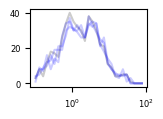

In [7]:
thr = 8
trials, neurons = 2000, 500
names = ["base", "Full rec. method", "No sparsity", "Non-local inhibition", "No Dale's law", "No TM", "No spike", "Sigmoid"]
colors = ["black", "blue", "red", "green", "purple", "orange", "brown", "pink"]
hypothesis = "withfb1"
bins = np.linspace(-1, 2, 30)
torch.manual_seed(0)
np.random.seed(0)
for hypothesis in ["nofb", "withfb1"]:
    opt = load_training_opt(logs[hypothesis][0])
    model_nofb = load_model_and_optimizer(opt, reload=True, last_best="best")[0]

    hit_miss_mean, hit_miss_var = np.zeros((8)), np.zeros((8))
    tloss_mean, tloss_var = np.zeros((8)), np.zeros((8))
    nloss_mean, nloss_var = np.zeros((8)), np.zeros((8))
    filt = lambda x: model_nofb.filter_fun2(model_nofb.filter_fun1(x))
    _, trial_type_nofb_0, _, spikes_nofb_0 = run_with_perturbation(model_nofb, trials=trials, area=0, exc=0, power=0, seed=0, thr=thr)
    del model_nofb
    fig_frdistro, ax_frdistro = plot_with_size(30, 20)
    ax_frdistro.set_xscale("log")
    for i, log in enumerate(logs[hypothesis]):
        opt = load_training_opt(log)
        model = load_model_and_optimizer(opt, reload=True, last_best="best")[0]
        name = give_name(model.opt.log_path)
        if name == "No spike + reset":
            continue
        _, trial_type_nofb, _, spikes_nofb = run_with_perturbation(model, trials=trials, area=0, exc=0, power=0, seed=2, thr=thr)
        tloss = trial_matched_mse(model, spikes_nofb_0, spikes_nofb)[0]
        nloss = neuron_loss(model, spikes_nofb_0, spikes_nofb)
        fr_dist = spikes_nofb[:50].mean((0,1)) / model.timestep
        # remove non-clear trials -- I do this for the No TM case, where you have a lot of intermediate trials
        keep = torch.isin(trial_type_nofb, torch.tensor([0,3], device=trial_type_nofb.device))
        trial_type_nofb = trial_type_nofb[keep]
        hr = (trial_type_nofb==3)*1.
        print(name, trial_type_nofb.unique(return_counts=True))
        j = names.index(name)
        div = 3 if name != "base" else 1
        hit_miss_mean[j] += hr.mean().item() / div
        hit_miss_var[j] += hr.var().item()
        tloss_mean[j] += tloss.mean().item() / div
        tloss_var[j] += tloss.var().item()
        nloss_mean[j] += nloss.mean().item() / div
        nloss_var[j] += nloss.var().item() 
        x, y = np.histogram(fr_dist.cpu().numpy().flatten(), bins=10**bins)
        ax_frdistro.plot(y[:-1], x, color=colors[j], alpha=0.2)
        del model
    fig_hit, ax_hit = plot_with_size(20, 15)
    for i in range(1, len(hit_miss_mean)):
        ax_hit.errorbar(i-1, hit_miss_mean[i], yerr=1.96*np.sqrt(np.array(hit_miss_var)[i]/trials), fmt="o", capsize=3, color=colors[i])
    ax_hit.set_xticks(range(len(names)-1))
    ax_hit.set_ylim(0.4, 0.8)
    fig_hit.savefig(f"FiguresOpto/Supplementary_Figure1/hit_{hypothesis}.pdf", dpi=300, bbox_inches="tight", transparent=True)

    fig_psth, ax_psth = plot_with_size(30, 20)
    for i in range(1, len(nloss_mean)):
        ax_psth.errorbar(i-1, nloss_mean[i], yerr=1.96*np.sqrt(np.array(nloss_var)[i]/neurons), fmt="o", capsize=3, color=colors[i])
    ax_psth.set_xticks(range(len(names)-1))
    fig_psth.savefig(f"FiguresOpto/Supplementary_Figure1/psth_{hypothesis}.pdf", dpi=300, bbox_inches="tight", transparent=True)

    fig_ttrial, ax_ttrial = plot_with_size(30, 20)
    for i in range(1, len(tloss_mean)):
        ax_ttrial.errorbar(i-1, tloss_mean[i], yerr=1.96*np.sqrt(np.array(tloss_var)[i]/trials), fmt="o", capsize=3, color=colors[i])
    ax_ttrial.set_xticks(range(len(names)-1))
    fig_ttrial.savefig(f"FiguresOpto/Supplementary_Figure1/ttrial_{hypothesis}.pdf", dpi=300, bbox_inches="tight", transparent=True)
    fig_frdistro.savefig(f"FiguresOpto/Supplementary_Figure1/frdistro_{hypothesis}.pdf", dpi=300, bbox_inches="tight", transparent=True)
    if hypothesis == "nofb":
        nloss_mean_nofb, nloss_std_nofb = nloss_mean, 1.96*np.sqrt(np.array(nloss_var)/neurons)
        tloss_mean_nofb, tloss_std_nofb = tloss_mean, 1.96*np.sqrt(np.array(tloss_var)/neurons)
    else:
        nloss_mean_withfb1, nloss_std_withfb1 = nloss_mean, 1.96*np.sqrt(np.array(nloss_var)/neurons)
        tloss_mean_withfb1, tloss_std_withfb1 = tloss_mean, 1.96*np.sqrt(np.array(tloss_var)/neurons)


In [9]:
def sem(x):
    return x / np.sqrt(493)
names = ["base", "Full rec. method", "No sparsity", "Non-local inhibition", "No Dale's law", "No TM", "No spike", "Sigmoid"]
def latex_table(table_psth_pear_mean_nofb, table_psth_pear_std_nofb, table_psth_pear_mean_withfb, table_psth_pear_std_withfb):
    for i in range(len(table_psth_pear_mean_nofb)):
        print(f"{names[i]} & {table_psth_pear_mean_nofb[i]:.2f} $\pm$ {table_psth_pear_std_nofb[i]:.2f} & {table_psth_pear_mean_withfb[i]:.2f} $\pm$ {table_psth_pear_std_withfb[i]:.2f} \\\\")


In [30]:
# prepare code for latex table, where first column is the name of the method, second the mean plus minus sem of the pearson correlation of the psth nofb, and third the mean plus minus sem of the pearson correlation of the psth withfb
def sem(x):
    return x / np.sqrt(493)
names = ["base", "Full rec. method", "No sparsity", "Non-local inhibition", "No Dale's law", "No TM", "No spike", "Sigmoid"]
def latex_table(table_psth_pear_mean_nofb, table_psth_pear_std_nofb, table_psth_pear_mean_withfb, table_psth_pear_std_withfb):
    for i in range(len(table_psth_pear_mean_nofb)):
        print(f"{names[i]} & {table_psth_pear_mean_nofb[i]:.2f} $\pm$ {table_psth_pear_std_nofb[i]:.2f} & {table_psth_pear_mean_withfb[i]:.2f} $\pm$ {table_psth_pear_std_withfb[i]:.2f} \\\\")

std = np.sqrt(np.array(nloss_var)[i]/neurons)
latex_table(nloss_mean_nofb, nloss_std_nofb, nloss_mean_withfb1, nloss_std_withfb1)
print("")
latex_table(tloss_mean_nofb, tloss_std_nofb, tloss_mean_withfb1, tloss_std_withfb1)

base & 0.18 $\pm$ 0.02 & 0.17 $\pm$ 0.02 \\
Full rec. method & 0.25 $\pm$ 0.05 & 0.25 $\pm$ 0.05 \\
No sparsity & 0.24 $\pm$ 0.04 & 0.25 $\pm$ 0.05 \\
Non-local inhibition & 0.28 $\pm$ 0.06 & 0.25 $\pm$ 0.05 \\
No Dale's law & 0.43 $\pm$ 0.11 & 0.37 $\pm$ 0.09 \\
No TM & 0.23 $\pm$ 0.04 & 0.22 $\pm$ 0.04 \\
No spike & 0.17 $\pm$ 0.06 & 0.17 $\pm$ 0.05 \\
Sigmoid & 0.25 $\pm$ 0.09 & 0.20 $\pm$ 0.05 \\

base & 0.25 $\pm$ 0.01 & 0.26 $\pm$ 0.01 \\
Full rec. method & 0.27 $\pm$ 0.02 & 0.28 $\pm$ 0.02 \\
No sparsity & 0.27 $\pm$ 0.02 & 0.28 $\pm$ 0.02 \\
Non-local inhibition & 0.28 $\pm$ 0.02 & 0.28 $\pm$ 0.02 \\
No Dale's law & 0.27 $\pm$ 0.02 & 0.25 $\pm$ 0.02 \\
No TM & 0.68 $\pm$ 0.04 & 0.54 $\pm$ 0.04 \\
No spike & 0.21 $\pm$ 0.02 & 0.22 $\pm$ 0.02 \\
Sigmoid & 0.21 $\pm$ 0.02 & 0.20 $\pm$ 0.02 \\


In [6]:
import pandas as pd
loss = True
loss_ext = "_loss" if loss else ""
df = pd.read_csv(f"FiguresOpto/nofb_t_trial{loss_ext}.csv")
df1 = pd.read_csv(f"FiguresOpto/withfb1_t_trial{loss_ext}.csv")
df = pd.concat([df, df1])
df.drop(columns=["Unnamed: 0"], inplace=True)

In [7]:
names = ["Full rec. method", "Sigmoid", "No sparsity", "Non-local inhibition", "No Dale's law", "No TM", "No spike"]
tloss_mean_area0_light_nofb = []
tloss_std_area0_light_nofb = []
for name in names:
    cond = (df["model_name"] == name) & (df["power"] >= 0.0) & (df["hypothesis"] == "nofb") 
    tloss_mean_area0_light_nofb.append(df[cond]["t_trial_21"].mean())
    tloss_std_area0_light_nofb.append(1.96 * (df[cond]["t_trial_21"].var()/3)**0.5)


tloss_mean_area0_light_withfb1 = []
tloss_std_area0_light_withfb1 = []
for name in names:
    cond = (df["model_name"] == name) & (df["power"] >= 0.0) & (df["hypothesis"] == "withfb1") 
    tloss_mean_area0_light_withfb1.append(df[cond]["t_trial_21"].mean())
    tloss_std_area0_light_withfb1.append(1.96 * (df[cond]["t_trial_21"].var()/3)**0.5)


In [10]:
latex_table(tloss_mean_area0_light_nofb, tloss_std_area0_light_nofb, tloss_mean_area0_light_withfb1, tloss_std_area0_light_withfb1)

base & 0.21 $\pm$ 0.05 & 0.20 $\pm$ 0.08 \\
Full rec. method & 0.47 $\pm$ 0.64 & 0.56 $\pm$ 0.53 \\
No sparsity & 0.48 $\pm$ 0.79 & 0.19 $\pm$ 0.06 \\
Non-local inhibition & 0.37 $\pm$ 0.31 & 0.68 $\pm$ 0.69 \\
No Dale's law & 0.41 $\pm$ 0.31 & 0.84 $\pm$ 1.11 \\
No TM & 0.38 $\pm$ 0.10 & 0.37 $\pm$ 0.09 \\
No spike & 0.18 $\pm$ 0.02 & 0.26 $\pm$ 0.15 \\


In [11]:
names = ["Full rec. method", "Sigmoid", "No sparsity", "Non-local inhibition", "No Dale's law", "No TM", "No spike"]
tloss_mean_area0_light_nofb = []
tloss_std_area0_light_nofb = []
for name in names:
    cond = (df["model_name"] == name) & (df["power"] == 0.0) & (df["hypothesis"] == "nofb") 
    tloss_mean_area0_light_nofb.append(df[cond]["t_trial_21"].mean())
    tloss_std_area0_light_nofb.append(1.96 * (df[cond]["t_trial_21"].var()/3)**0.5)


tloss_mean_area0_light_withfb1 = []
tloss_std_area0_light_withfb1 = []
for name in names:
    cond = (df["model_name"] == name) & (df["power"] == 0.0) & (df["hypothesis"] == "withfb1") 
    tloss_mean_area0_light_withfb1.append(df[cond]["t_trial_21"].mean())
    tloss_std_area0_light_withfb1.append(1.96 * (df[cond]["t_trial_21"].var()/3)**0.5)


In [12]:
latex_table(tloss_mean_area0_light_nofb, tloss_std_area0_light_nofb, tloss_mean_area0_light_withfb1, tloss_std_area0_light_withfb1)

Full rec. method & 0.19 $\pm$ 0.01 & 0.18 $\pm$ 0.01 \\
Sigmoid & 0.16 $\pm$ 0.01 & 0.17 $\pm$ 0.01 \\
No sparsity & 0.20 $\pm$ 0.01 & 0.19 $\pm$ 0.01 \\
Non-local inhibition & 0.20 $\pm$ 0.02 & 0.18 $\pm$ 0.01 \\
No Dale's law & 0.18 $\pm$ 0.01 & 0.18 $\pm$ 0.01 \\
No TM & 0.33 $\pm$ 0.01 & 0.35 $\pm$ 0.03 \\
No spike & 0.17 $\pm$ 0.00 & 0.18 $\pm$ 0.00 \\


In [ ]:
# bioRNN & 0.18 $\pm$ 0.02 & 0.19 $\pm$ 0.02 \\
# $\sigma$RNN & 0.16 $\pm$ 0.02 & 0.16 $\pm$ 0.02 \\
# \hline
# No sparsity & 0.19 $\pm$ 0.02 & 0.19 $\pm$ 0.02 \\
# Non-local inhibition & 0.19 $\pm$ 0.02 & 0.18 $\pm$ 0.02 \\
# No Dale's law & 0.19 $\pm$ 0.02 & 0.18 $\pm$ 0.02 \\
# No TM & 0.38 $\pm$ 0.03 & 0.35 $\pm$ 0.03 \\
# No spike & 0.16 $\pm$ 0.02 & 0.17 $\pm$ 0.02 \\